# Import libraries

In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import IsolationForest

# Load data

In [3]:
data = pd.read_csv("../../data_anomaly/tsfreshfeatures.csv")

In [4]:
data.rename(columns={"Unnamed: 0": "index"}, inplace=True)

In [5]:
data.set_index("index", inplace=True)

# Data pré-processing

## Removing empty columns

In [6]:
cols = data.isna().mean() != 0

In [7]:
nan_cols = cols[cols == True].index

In [8]:
empty_col = data[nan_cols].isna().mean() == 1

In [9]:
data.drop(columns=empty_col[empty_col == True].index.tolist(), inplace=True)

## Removing constant columns

In [10]:
data.shape

(1637, 8113)

In [11]:
data = data.loc[:, (data != data.iloc[0]).any()]

In [12]:
data.shape

(1637, 7501)

## Remove last nans

In [14]:
test = data.replace([np.inf, -np.inf], np.nan)
data_cleaned = test.dropna(axis=1)

In [16]:
data_cleaned = data_cleaned[data_cleaned.columns.drop(list(data_cleaned.filter(regex='day')))]

In [17]:
data_cleaned = data_cleaned[data_cleaned.columns.drop(list(data_cleaned.filter(regex='cycle')))]

In [18]:
data_cleaned = data_cleaned[data_cleaned.columns.drop(list(data_cleaned.filter(regex='window')))]

In [19]:
data_cleaned.shape

(1637, 2428)

# Détection d'anomalies

In [20]:
iforest = IsolationForest(
    n_estimators=100,
    max_samples="auto",
    contamination=0.05,
    max_features=4,
    bootstrap=False,
    n_jobs=-1,
    random_state=1,
)

In [21]:
pred = iforest.fit_predict(data_cleaned)
data_cleaned["scores"] = iforest.decision_function(data_cleaned)
data_cleaned["anomaly_label"] = pred

/home/rico/miniconda3/envs/AML/lib/python3.8/site-packages/sklearn/base.py:445: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


In [22]:
data_cleaned[data_cleaned.anomaly_label == -1]

,p1__variance_larger_than_standard_deviation,p1__has_duplicate_max,p1__has_duplicate_min,p1__has_duplicate,p1__sum_values,p1__abs_energy,p1__mean_abs_change,p1__mean_change,p1__median,p1__mean,...,p11__ratio_beyond_r_sigma__r_7,p11__count_above__t_0,p11__count_below__t_0,p11__lempel_ziv_complexity__bins_2,p11__lempel_ziv_complexity__bins_3,p11__lempel_ziv_complexity__bins_5,p11__lempel_ziv_complexity__bins_10,p11__lempel_ziv_complexity__bins_100,scores,anomaly_label
index,,,,,,,,,,,,,,,,,,,,,
1_1_1,0.0,1.0,0.0,1.0,-192.614108,405.598886,0.068423,-0.010094,-1.849016,-1.926141,...,0.0,0.000000,1.000000,0.170000,0.250000,0.290000,0.390000,0.570000,-0.072778,-1
1_1_3,0.0,1.0,0.0,1.0,-153.435714,256.272205,0.053100,-0.009498,-1.448777,-1.534357,...,0.0,0.000000,1.000000,0.130000,0.200000,0.270000,0.400000,0.620000,-0.019914,-1
1_1_5,0.0,1.0,1.0,1.0,-73.271465,68.510674,0.033989,0.013662,-0.874543,-0.732715,...,0.0,0.000000,1.000000,0.160000,0.220000,0.270000,0.340000,0.550000,-0.033595,-1
1_1_62,1.0,1.0,1.0,1.0,33.639019,130.093035,0.039117,-0.019964,0.011388,0.336390,...,0.0,0.420000,0.580000,0.160000,0.220000,0.280000,0.360000,0.550000,-0.038153,-1
1_1_68,1.0,0.0,1.0,1.0,-142.969225,367.268092,0.040963,0.040719,-1.528748,-1.906256,...,0.0,0.133333,0.866667,0.186667,0.240000,0.333333,0.360000,0.573333,-0.100211,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4_3_60,0.0,0.0,1.0,1.0,-70.595492,63.553967,0.020781,0.013343,-0.618099,-0.705955,...,0.0,1.000000,0.000000,0.180000,0.200000,0.270000,0.320000,0.490000,-0.007908,-1
4_3_61,0.0,0.0,1.0,1.0,-98.497577,116.810033,0.029819,-0.014069,-1.040702,-0.984976,...,0.0,1.000000,0.000000,0.170000,0.220000,0.310000,0.410000,0.590000,-0.037801,-1
4_3_63,0.0,1.0,1.0,1.0,-89.053723,127.656481,0.021805,0.018173,-1.225659,-0.890537,...,0.0,0.890000,0.110000,0.160000,0.210000,0.230000,0.290000,0.440000,-0.050739,-1


In [24]:
data_cleaned["anomaly"] = data_cleaned["anomaly_label"].apply(
    lambda x: "outlier" if x == -1 else "inlier"
)

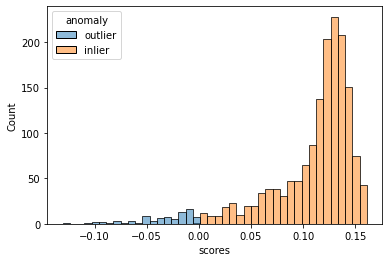

In [25]:
fig = sns.histplot(data=data_cleaned, x="scores", hue="anomaly")
plt.show()

Having said that, If you are very confident about the results of Isolation Forest classifier and you have a capacity to train another model then you could use the output of Isolation Forest i.e -1/1 values as target-class to train a Random Forest classifier. This will give you feature importance for detecting anomaly.

In [26]:
data_cleaned.to_csv("../data/tsfresh_data_cleaned.csv")